# Data cleaning

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import config
jdbc_url=config.DB_PATH
# Create Engine
engine = create_engine(jdbc_url)
conn = engine.connect()
data = pd.read_sql("SELECT * FROM historical", conn)
data.head()

,index,crypto,time,open,high,low,close,volume,trade
0,0,bitcoin_usdt,1.511914e+09,9896.79000000,11300.03000000,8520.00000000,9687.88000000,13352.53871500,8662.63236200
1,1,bitcoin_usdt,1.512000e+09,9687.88000000,10900.00000000,8850.80000000,9838.96000000,9389.57432900,5360.66024200
2,2,bitcoin_usdt,1.512086e+09,9837.00000000,10898.00000000,9380.00000000,10782.99000000,6134.92363300,3269.86858800
3,3,bitcoin_usdt,1.512173e+09,10775.04000000,11190.00000000,10620.00000000,10890.01000000,4765.43975700,2390.19427500
4,4,bitcoin_usdt,1.512259e+09,10902.69000000,11825.00000000,10500.00000000,11165.41000000,5346.63652400,2574.24618700


In [2]:
eth_df = data[data['crypto'].str.contains('ethereum_usdt',case=False, na=False)]
eth_df.shape

(1462, 9)

In [3]:
df1 = eth_df.reset_index()['close']

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
eth_scaled = scaler.fit_transform(np.array(df1).reshape(-1, 1))
eth_scaled.shape

(1462, 1)

In [5]:
#split dataset into train and test
train_size = int(len(eth_scaled)*0.70)
test_size = len(eth_scaled) - train_size
train_data, test_data = eth_scaled[0:train_size,:],eth_scaled[train_size:len(eth_scaled),:1]
print(train_data.shape, test_data.shape)

(1023, 1) (439, 1)


In [6]:
def create_data(data, timestep):
  x_data = []
  y_data = []

  for i in range(timestep, data.size):
    x_data.append(data[i-timestep:i, 0])
    y_data.append(data[i, 0])
  return np.array(x_data), np.array(y_data)

In [7]:
#assuming the timestep of 150 days, applying the function to our train and test data
timestep = 150
X_train, y_train = create_data(train_data, timestep)
X_test, y_test = create_data(test_data,timestep)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(873, 150)
(873,)
(289, 150)
(289,)


(None, None)

In [8]:
#RNN expects the data being fed to be transformed from 2d array to 3d
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(873, 150, 1)
(873,)
(289, 150, 1)
(289,)


(None, None)

# LSTM model

We use Sequential module from Keras that allows to create a Neural Network object with sequential layers. Then, we add LSTM layers and given that predicting a price of a coin is a quite complex task we use 50 LSTM units per LSTM layer and we use multiple LSTM layers. We also add a Dropout layer, for regularization to ignore part of the neurons in the LSTM layers and avoid overfitting. Finally, we use the Dense module to add an output layer

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.metrics import MeanSquaredError

regressor = Sequential()
regressor.add(LSTM(50, return_sequences=True, input_shape=(150,1)))
regressor.add(LSTM(50, return_sequences=True))
regressor.add(LSTM(50))
regressor.add(Dense(1))
regressor.compile(loss='mean_squared_error', optimizer='adam')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 150, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [10]:
def create_model(LSTMtune):
  LSTM_tune = Sequential()

  # LSTM layer 1
  units_param = LSTMtune.Int('first_units', min_value=1, max_value=50)
  LSTM_tune.add(LSTM(units = units_param, return_sequences=True, input_shape = (X_train.shape[1], 1)))
  LSTM_tune.add(Dropout(0.2))

  for i in range(LSTMtune.Int('num_layers', 1, 6)):
    units_param = LSTMtune.Int('units_'+str(i), min_value=1, max_value=50)
    LSTM_tune.add(LSTM(units = units_param, return_sequences=True))
    LSTM_tune.add(Dropout(0.2))

# LSTM layer
  units_param = LSTMtune.Int('last_units', min_value=1, max_value=50)
  LSTM_tune.add(LSTM(units = units_param))
  LSTM_tune.add(Dropout(0.2))

# Fully connected layer
  LSTM_tune.add(Dense(units = 1))

# Compiling the RNN
  LSTM_tune.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=["mean_squared_error"])

  return LSTM_tune
#Fitting the RNN model

In [11]:
import keras_tuner
tuner = keras_tuner.Hyperband(
    create_model,
    objective=keras_tuner.Objective("mean_squared_error", direction="min"),
    max_epochs=100,
    hyperband_iterations=1
)

In [12]:
tuner.search(X_train, y_train, validation_data=(X_test,y_test))

Trial 254 Complete [00h 07m 24s]
mean_squared_error: 4.5328786654863507e-05

Best mean_squared_error So Far: 3.0979543225839734e-05
Total elapsed time: 03h 42m 31s
INFO:tensorflow:Oracle triggered exit


In [13]:
best_LSTM=tuner.get_best_hyperparameters(1)[0]
LSTM_best = tuner.hypermodel.build(best_LSTM)
best_LSTM.values

{'first_units': 37,
 'num_layers': 1,
 'units_0': 31,
 'last_units': 43,
 'units_1': 43,
 'units_2': 3,
 'units_3': 33,
 'units_4': 22,
 'units_5': 13,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 4,
 'tuner/round': 4,
 'tuner/trial_id': '2cc76c9fa889f468b9fdcc394cbb14fa'}

In [14]:
regressor.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 7s 275ms/step - loss: 6.3462e-04 - val_loss: 0.0331
Epoch 2/100
14/14 [==============================] - 2s 177ms/step - loss: 1.3648e-04 - val_loss: 0.0383
Epoch 3/100
14/14 [==============================] - 2s 178ms/step - loss: 9.2344e-05 - val_loss: 0.0106
Epoch 4/100
14/14 [==============================] - 2s 177ms/step - loss: 7.0277e-05 - val_loss: 0.0151
Epoch 5/100
14/14 [==============================] - 2s 178ms/step - loss: 6.6497e-05 - val_loss: 0.0095
Epoch 6/100
14/14 [==============================] - 2s 179ms/step - loss: 5.8036e-05 - val_loss: 0.0094
Epoch 7/100
14/14 [==============================] - 2s 177ms/step - loss: 5.0626e-05 - val_loss: 0.0102
Epoch 8/100
14/14 [==============================] - 2s 178ms/step - loss: 4.5271e-05 - val_loss: 0.0075
Epoch 9/100
14/14 [==============================] - 2s 179ms/step - loss: 4.5616e-05 - val_loss: 0.0071
Epoch 10/100
14/14 [==============================] - 2

14/14 [==============================] - 2s 178ms/step - loss: 2.1400e-05 - val_loss: 0.0026
Epoch 79/100
14/14 [==============================] - 2s 179ms/step - loss: 2.0315e-05 - val_loss: 0.0025
Epoch 80/100
14/14 [==============================] - 2s 179ms/step - loss: 2.4163e-05 - val_loss: 0.0045
Epoch 81/100
14/14 [==============================] - 2s 179ms/step - loss: 2.0047e-05 - val_loss: 0.0029
Epoch 82/100
14/14 [==============================] - 2s 179ms/step - loss: 1.9526e-05 - val_loss: 0.0043
Epoch 83/100
14/14 [==============================] - 3s 181ms/step - loss: 1.9523e-05 - val_loss: 0.0024
Epoch 84/100
14/14 [==============================] - 2s 179ms/step - loss: 1.9664e-05 - val_loss: 0.0043
Epoch 85/100
14/14 [==============================] - 2s 178ms/step - loss: 2.0648e-05 - val_loss: 0.0036
Epoch 86/100
14/14 [==============================] - 2s 179ms/step - loss: 1.9067e-05 - val_loss: 0.0050
Epoch 87/100
14/14 [==============================] - 2s 18

In [15]:
LSTM_best.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 7s 245ms/step - loss: 7.6581e-04 - mean_squared_error: 7.6581e-04 - val_loss: 0.1444 - val_mean_squared_error: 0.1444
Epoch 2/100
14/14 [==============================] - 3s 181ms/step - loss: 1.9488e-04 - mean_squared_error: 1.9488e-04 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 3/100
14/14 [==============================] - 3s 185ms/step - loss: 1.3239e-04 - mean_squared_error: 1.3239e-04 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 4/100
14/14 [==============================] - 3s 180ms/step - loss: 9.2302e-05 - mean_squared_error: 9.2302e-05 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 5/100
14/14 [==============================] - 3s 183ms/step - loss: 9.3661e-05 - mean_squared_error: 9.3661e-05 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 6/100
14/14 [==============================] - 3s 181ms/step - loss: 8.6609e-05 - mean_squared_error: 8.6609e-05 - val_loss: 0.0141 - val_m

Epoch 49/100
14/14 [==============================] - 3s 180ms/step - loss: 4.8683e-05 - mean_squared_error: 4.8683e-05 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 50/100
14/14 [==============================] - 3s 182ms/step - loss: 4.7611e-05 - mean_squared_error: 4.7611e-05 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 51/100
14/14 [==============================] - 3s 181ms/step - loss: 4.1417e-05 - mean_squared_error: 4.1417e-05 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 52/100
14/14 [==============================] - 2s 179ms/step - loss: 3.8949e-05 - mean_squared_error: 3.8949e-05 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 53/100
14/14 [==============================] - 2s 179ms/step - loss: 4.2363e-05 - mean_squared_error: 4.2363e-05 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 54/100
14/14 [==============================] - 3s 182ms/step - loss: 4.1435e-05 - mean_squared_error: 4.1435e-05 - val_loss: 0.0043 -

14/14 [==============================] - 3s 181ms/step - loss: 3.5866e-05 - mean_squared_error: 3.5866e-05 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 97/100
14/14 [==============================] - 3s 182ms/step - loss: 3.3272e-05 - mean_squared_error: 3.3272e-05 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 98/100
14/14 [==============================] - 2s 178ms/step - loss: 3.3185e-05 - mean_squared_error: 3.3185e-05 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 99/100
14/14 [==============================] - 3s 183ms/step - loss: 2.8852e-05 - mean_squared_error: 2.8852e-05 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 100/100
14/14 [==============================] - 2s 179ms/step - loss: 2.8260e-05 - mean_squared_error: 2.8260e-05 - val_loss: 0.0033 - val_mean_squared_error: 0.0033


## Prediction

In [16]:
#make predictions using train and test data
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [17]:
train_pred_tune = LSTM_best.predict(X_train)
test_pred_tune = LSTM_best.predict(X_test)

In [18]:
#tranformation to original form and making the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [19]:
train_pred_tune = scaler.inverse_transform(train_pred_tune)
test_pred_tune = scaler.inverse_transform(test_pred_tune)

In [20]:
y_train_reshape = y_train.reshape(-1, 1)
y_test_reshape = y_test.reshape(-1, 1)
y_train_inverse = scaler.inverse_transform(y_train_reshape)
y_test_inverse = scaler.inverse_transform(y_test_reshape)

In [21]:
#check the performance of the model prediction
import math
from sklearn.metrics import mean_squared_error, r2_score
print(f"Train RMSE:{math.sqrt(mean_squared_error(y_train_inverse,train_predict))}")
print(f"Train MSE:{mean_squared_error(y_train_inverse,train_predict)}")
print("-------------------------------")
print(f"Test RMSE:{math.sqrt(mean_squared_error(y_test_inverse,test_predict))}")
print(f"Test MSE:{mean_squared_error(y_test_inverse,test_predict)}")
print(f"R2 score:{r2_score(y_test_inverse,test_predict)}")

Train RMSE:17.704139196647365
Train MSE:313.43654469426565
-------------------------------
Test RMSE:226.00027570822607
Test MSE:51076.1246201942
R2 score:0.9364831526929527


In [22]:
print(f"Train RMSE:{math.sqrt(mean_squared_error(y_train_inverse,train_pred_tune))}")
print(f"Train MSE:{mean_squared_error(y_train_inverse,train_pred_tune)}")
print("-------------------------------")
print(f"Test RMSE:{math.sqrt(mean_squared_error(y_test_inverse,test_pred_tune))}")
print(f"Test MSE:{mean_squared_error(y_test_inverse,test_pred_tune)}")
print(f"R2 score:{r2_score(y_test_inverse,test_pred_tune)}")

Train RMSE:22.45373636669453
Train MSE:504.1702768250205
-------------------------------
Test RMSE:270.15347991900774
Test MSE:72982.9027123497
R2 score:0.9092404930468707


## Charts

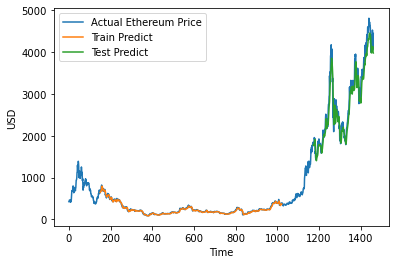

In [23]:
#create empty numpy array then add the train and test data, this way we can shape the data
import matplotlib.pyplot as plt
timepoints = 150

train_predict_plot=np.empty_like(eth_scaled)
train_predict_plot[:,:]=np.nan
train_predict_plot[timepoints:len(train_predict)+timepoints,:]=train_predict
#shift test predictions for plotting
test_predict_plot=np.empty_like(eth_scaled)
test_predict_plot[:,:]=np.nan
test_predict_plot[len(train_predict)+(timepoints*2):len(eth_scaled),:]=test_predict
#plot baseline and prediction
plt.plot(scaler.inverse_transform(eth_scaled), label= 'Actual Ethereum Price')
plt.plot(train_predict_plot, label= 'Train Predict')
plt.plot(test_predict_plot, label= 'Test Predict')
plt.xlabel("Time")
plt.ylabel("USD")
plt.legend()
plt.show()

## Predict for the future

In [24]:
x_input=test_data[289:].reshape(1,-1)
temp_input=list(x_input)
print(x_input.shape)
temp_input=temp_input[0].tolist()
len(temp_input)

(1, 150)


150

In [25]:
# demonstrate prediction for next 90 days
output=[]
n_steps=150
i=0
while(i<90):
    
    if(len(temp_input)>150):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        prediction = regressor.predict(x_input, verbose=0)
        print("{} day output {}".format(i,prediction))
        temp_input.extend(prediction[0].tolist())
        temp_input=temp_input[1:]
        output.extend(prediction.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        prediction = regressor.predict(x_input, verbose=0)
        temp_input.extend(prediction[0].tolist())
        output.extend(prediction.tolist())
        i=i+1

1 day input [0.47392585 0.44722092 0.47388564 0.4726304  0.43024457 0.43673453
 0.42905072 0.43535017 0.4123051  0.39295164 0.40447312 0.38858267
 0.37942772 0.3843661  0.38268328 0.36725004 0.36032827 0.40466786
 0.41081914 0.43192104 0.44472738 0.44579423 0.45389927 0.46901499
 0.46931345 0.48667505 0.5033741  0.51803049 0.52324617 0.5340924
 0.51337152 0.55903832 0.58067364 0.59434573 0.6512292  0.6198039
 0.65127365 0.64728146 0.65126942 0.62702414 0.68552269 0.67299999
 0.68229888 0.64831231 0.61977639 0.62037543 0.65626918 0.67758487
 0.66459013 0.66767424 0.68530255 0.65341157 0.6653183  0.63702368
 0.67517812 0.6690459  0.6645986  0.66590464 0.70814653 0.79231281
 0.78363412 0.81587013 0.80473814 0.81844834 0.81346974 0.70928323
 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677 0.67769706
 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972 0.68685624
 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713 0.60072774
 0.62986271 0.60154481 0.57599985 0.58563953 0.61742

5 day output [[0.7577379]]
6 day input [0.43673453 0.42905072 0.43535017 0.4123051  0.39295164 0.40447312
 0.38858267 0.37942772 0.3843661  0.38268328 0.36725004 0.36032827
 0.40466786 0.41081914 0.43192104 0.44472738 0.44579423 0.45389927
 0.46901499 0.46931345 0.48667505 0.5033741  0.51803049 0.52324617
 0.5340924  0.51337152 0.55903832 0.58067364 0.59434573 0.6512292
 0.6198039  0.65127365 0.64728146 0.65126942 0.62702414 0.68552269
 0.67299999 0.68229888 0.64831231 0.61977639 0.62037543 0.65626918
 0.67758487 0.66459013 0.66767424 0.68530255 0.65341157 0.6653183
 0.63702368 0.67517812 0.6690459  0.6645986  0.66590464 0.70814653
 0.79231281 0.78363412 0.81587013 0.80473814 0.81844834 0.81346974
 0.70928323 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677
 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972
 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713
 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953 0.61742468
 0.6828958  0.69937471 0.

10 day output [[0.6838235]]
11 day input [0.40447312 0.38858267 0.37942772 0.3843661  0.38268328 0.36725004
 0.36032827 0.40466786 0.41081914 0.43192104 0.44472738 0.44579423
 0.45389927 0.46901499 0.46931345 0.48667505 0.5033741  0.51803049
 0.52324617 0.5340924  0.51337152 0.55903832 0.58067364 0.59434573
 0.6512292  0.6198039  0.65127365 0.64728146 0.65126942 0.62702414
 0.68552269 0.67299999 0.68229888 0.64831231 0.61977639 0.62037543
 0.65626918 0.67758487 0.66459013 0.66767424 0.68530255 0.65341157
 0.6653183  0.63702368 0.67517812 0.6690459  0.6645986  0.66590464
 0.70814653 0.79231281 0.78363412 0.81587013 0.80473814 0.81844834
 0.81346974 0.70928323 0.72292146 0.70724268 0.66150603 0.67385727
 0.70285677 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254
 0.70950972 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601
 0.60216713 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953
 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778 0.72636541
 0.73898548 0.74164836

15 day output [[0.62333524]]
16 day input [0.36725004 0.36032827 0.40466786 0.41081914 0.43192104 0.44472738
 0.44579423 0.45389927 0.46901499 0.46931345 0.48667505 0.5033741
 0.51803049 0.52324617 0.5340924  0.51337152 0.55903832 0.58067364
 0.59434573 0.6512292  0.6198039  0.65127365 0.64728146 0.65126942
 0.62702414 0.68552269 0.67299999 0.68229888 0.64831231 0.61977639
 0.62037543 0.65626918 0.67758487 0.66459013 0.66767424 0.68530255
 0.65341157 0.6653183  0.63702368 0.67517812 0.6690459  0.6645986
 0.66590464 0.70814653 0.79231281 0.78363412 0.81587013 0.80473814
 0.81844834 0.81346974 0.70928323 0.72292146 0.70724268 0.66150603
 0.67385727 0.70285677 0.67769706 0.70924089 0.74716884 0.73752281
 0.7019254  0.70950972 0.68685624 0.61248629 0.5677424  0.63357761
 0.64957601 0.60216713 0.60072774 0.62986271 0.60154481 0.57599985
 0.58563953 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778
 0.72636541 0.73898548 0.74164836 0.73649618 0.73897067 0.70497564
 0.73204889 0.72132543

20 day output [[0.5619473]]
21 day input [0.44472738 0.44579423 0.45389927 0.46901499 0.46931345 0.48667505
 0.5033741  0.51803049 0.52324617 0.5340924  0.51337152 0.55903832
 0.58067364 0.59434573 0.6512292  0.6198039  0.65127365 0.64728146
 0.65126942 0.62702414 0.68552269 0.67299999 0.68229888 0.64831231
 0.61977639 0.62037543 0.65626918 0.67758487 0.66459013 0.66767424
 0.68530255 0.65341157 0.6653183  0.63702368 0.67517812 0.6690459
 0.6645986  0.66590464 0.70814653 0.79231281 0.78363412 0.81587013
 0.80473814 0.81844834 0.81346974 0.70928323 0.72292146 0.70724268
 0.66150603 0.67385727 0.70285677 0.67769706 0.70924089 0.74716884
 0.73752281 0.7019254  0.70950972 0.68685624 0.61248629 0.5677424
 0.63357761 0.64957601 0.60216713 0.60072774 0.62986271 0.60154481
 0.57599985 0.58563953 0.61742468 0.6828958  0.69937471 0.70571862
 0.69906778 0.72636541 0.73898548 0.74164836 0.73649618 0.73897067
 0.70497564 0.73204889 0.72132543 0.74587128 0.7846925  0.80123915
 0.79297747 0.79655266 

25 day output [[0.50548035]]
26 day input [0.48667505 0.5033741  0.51803049 0.52324617 0.5340924  0.51337152
 0.55903832 0.58067364 0.59434573 0.6512292  0.6198039  0.65127365
 0.64728146 0.65126942 0.62702414 0.68552269 0.67299999 0.68229888
 0.64831231 0.61977639 0.62037543 0.65626918 0.67758487 0.66459013
 0.66767424 0.68530255 0.65341157 0.6653183  0.63702368 0.67517812
 0.6690459  0.6645986  0.66590464 0.70814653 0.79231281 0.78363412
 0.81587013 0.80473814 0.81844834 0.81346974 0.70928323 0.72292146
 0.70724268 0.66150603 0.67385727 0.70285677 0.67769706 0.70924089
 0.74716884 0.73752281 0.7019254  0.70950972 0.68685624 0.61248629
 0.5677424  0.63357761 0.64957601 0.60216713 0.60072774 0.62986271
 0.60154481 0.57599985 0.58563953 0.61742468 0.6828958  0.69937471
 0.70571862 0.69906778 0.72636541 0.73898548 0.74164836 0.73649618
 0.73897067 0.70497564 0.73204889 0.72132543 0.74587128 0.7846925
 0.80123915 0.79297747 0.79655266 0.77498508 0.80294101 0.86308216
 0.84018737 0.8230861

30 day output [[0.45704353]]
31 day input [0.51337152 0.55903832 0.58067364 0.59434573 0.6512292  0.6198039
 0.65127365 0.64728146 0.65126942 0.62702414 0.68552269 0.67299999
 0.68229888 0.64831231 0.61977639 0.62037543 0.65626918 0.67758487
 0.66459013 0.66767424 0.68530255 0.65341157 0.6653183  0.63702368
 0.67517812 0.6690459  0.6645986  0.66590464 0.70814653 0.79231281
 0.78363412 0.81587013 0.80473814 0.81844834 0.81346974 0.70928323
 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677 0.67769706
 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972 0.68685624
 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713 0.60072774
 0.62986271 0.60154481 0.57599985 0.58563953 0.61742468 0.6828958
 0.69937471 0.70571862 0.69906778 0.72636541 0.73898548 0.74164836
 0.73649618 0.73897067 0.70497564 0.73204889 0.72132543 0.74587128
 0.7846925  0.80123915 0.79297747 0.79655266 0.77498508 0.80294101
 0.86308216 0.84018737 0.82308614 0.86434586 0.84639792 0.87561756
 0.85681022 0.81246005

35 day output [[0.41471174]]
36 day input [0.6198039  0.65127365 0.64728146 0.65126942 0.62702414 0.68552269
 0.67299999 0.68229888 0.64831231 0.61977639 0.62037543 0.65626918
 0.67758487 0.66459013 0.66767424 0.68530255 0.65341157 0.6653183
 0.63702368 0.67517812 0.6690459  0.6645986  0.66590464 0.70814653
 0.79231281 0.78363412 0.81587013 0.80473814 0.81844834 0.81346974
 0.70928323 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677
 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972
 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713
 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953 0.61742468
 0.6828958  0.69937471 0.70571862 0.69906778 0.72636541 0.73898548
 0.74164836 0.73649618 0.73897067 0.70497564 0.73204889 0.72132543
 0.74587128 0.7846925  0.80123915 0.79297747 0.79655266 0.77498508
 0.80294101 0.86308216 0.84018737 0.82308614 0.86434586 0.84639792
 0.87561756 0.85681022 0.81246005 0.88951404 0.91763931 0.89727405
 0.88976593 0.8965861

40 day output [[0.37740391]]
41 day input [0.68552269 0.67299999 0.68229888 0.64831231 0.61977639 0.62037543
 0.65626918 0.67758487 0.66459013 0.66767424 0.68530255 0.65341157
 0.6653183  0.63702368 0.67517812 0.6690459  0.6645986  0.66590464
 0.70814653 0.79231281 0.78363412 0.81587013 0.80473814 0.81844834
 0.81346974 0.70928323 0.72292146 0.70724268 0.66150603 0.67385727
 0.70285677 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254
 0.70950972 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601
 0.60216713 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953
 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778 0.72636541
 0.73898548 0.74164836 0.73649618 0.73897067 0.70497564 0.73204889
 0.72132543 0.74587128 0.7846925  0.80123915 0.79297747 0.79655266
 0.77498508 0.80294101 0.86308216 0.84018737 0.82308614 0.86434586
 0.84639792 0.87561756 0.85681022 0.81246005 0.88951404 0.91763931
 0.89727405 0.88976593 0.8965861  0.95383577 0.95668491 0.94164963
 0.92935553 0.9386184

45 day output [[0.3448634]]
46 day input [0.62037543 0.65626918 0.67758487 0.66459013 0.66767424 0.68530255
 0.65341157 0.6653183  0.63702368 0.67517812 0.6690459  0.6645986
 0.66590464 0.70814653 0.79231281 0.78363412 0.81587013 0.80473814
 0.81844834 0.81346974 0.70928323 0.72292146 0.70724268 0.66150603
 0.67385727 0.70285677 0.67769706 0.70924089 0.74716884 0.73752281
 0.7019254  0.70950972 0.68685624 0.61248629 0.5677424  0.63357761
 0.64957601 0.60216713 0.60072774 0.62986271 0.60154481 0.57599985
 0.58563953 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778
 0.72636541 0.73898548 0.74164836 0.73649618 0.73897067 0.70497564
 0.73204889 0.72132543 0.74587128 0.7846925  0.80123915 0.79297747
 0.79655266 0.77498508 0.80294101 0.86308216 0.84018737 0.82308614
 0.86434586 0.84639792 0.87561756 0.85681022 0.81246005 0.88951404
 0.91763931 0.89727405 0.88976593 0.8965861  0.95383577 0.95668491
 0.94164963 0.92935553 0.93861844 0.95864079 1.         0.98398677
 0.96206781 0.98116514

50 day output [[0.31644323]]
51 day input [0.68530255 0.65341157 0.6653183  0.63702368 0.67517812 0.6690459
 0.6645986  0.66590464 0.70814653 0.79231281 0.78363412 0.81587013
 0.80473814 0.81844834 0.81346974 0.70928323 0.72292146 0.70724268
 0.66150603 0.67385727 0.70285677 0.67769706 0.70924089 0.74716884
 0.73752281 0.7019254  0.70950972 0.68685624 0.61248629 0.5677424
 0.63357761 0.64957601 0.60216713 0.60072774 0.62986271 0.60154481
 0.57599985 0.58563953 0.61742468 0.6828958  0.69937471 0.70571862
 0.69906778 0.72636541 0.73898548 0.74164836 0.73649618 0.73897067
 0.70497564 0.73204889 0.72132543 0.74587128 0.7846925  0.80123915
 0.79297747 0.79655266 0.77498508 0.80294101 0.86308216 0.84018737
 0.82308614 0.86434586 0.84639792 0.87561756 0.85681022 0.81246005
 0.88951404 0.91763931 0.89727405 0.88976593 0.8965861  0.95383577
 0.95668491 0.94164963 0.92935553 0.93861844 0.95864079 1.
 0.98398677 0.96206781 0.98116514 0.96983206 0.96534878 0.96158519
 0.94830893 0.87337169 0.88989

55 day output [[0.2913713]]
56 day input [0.6690459  0.6645986  0.66590464 0.70814653 0.79231281 0.78363412
 0.81587013 0.80473814 0.81844834 0.81346974 0.70928323 0.72292146
 0.70724268 0.66150603 0.67385727 0.70285677 0.67769706 0.70924089
 0.74716884 0.73752281 0.7019254  0.70950972 0.68685624 0.61248629
 0.5677424  0.63357761 0.64957601 0.60216713 0.60072774 0.62986271
 0.60154481 0.57599985 0.58563953 0.61742468 0.6828958  0.69937471
 0.70571862 0.69906778 0.72636541 0.73898548 0.74164836 0.73649618
 0.73897067 0.70497564 0.73204889 0.72132543 0.74587128 0.7846925
 0.80123915 0.79297747 0.79655266 0.77498508 0.80294101 0.86308216
 0.84018737 0.82308614 0.86434586 0.84639792 0.87561756 0.85681022
 0.81246005 0.88951404 0.91763931 0.89727405 0.88976593 0.8965861
 0.95383577 0.95668491 0.94164963 0.92935553 0.93861844 0.95864079
 1.         0.98398677 0.96206781 0.98116514 0.96983206 0.96534878
 0.96158519 0.94830893 0.87337169 0.88989082 0.82831452 0.89136408
 0.91621686 0.88364852 

60 day output [[0.2690615]]
61 day input [0.78363412 0.81587013 0.80473814 0.81844834 0.81346974 0.70928323
 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677 0.67769706
 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972 0.68685624
 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713 0.60072774
 0.62986271 0.60154481 0.57599985 0.58563953 0.61742468 0.6828958
 0.69937471 0.70571862 0.69906778 0.72636541 0.73898548 0.74164836
 0.73649618 0.73897067 0.70497564 0.73204889 0.72132543 0.74587128
 0.7846925  0.80123915 0.79297747 0.79655266 0.77498508 0.80294101
 0.86308216 0.84018737 0.82308614 0.86434586 0.84639792 0.87561756
 0.85681022 0.81246005 0.88951404 0.91763931 0.89727405 0.88976593
 0.8965861  0.95383577 0.95668491 0.94164963 0.92935553 0.93861844
 0.95864079 1.         0.98398677 0.96206781 0.98116514 0.96983206
 0.96534878 0.96158519 0.94830893 0.87337169 0.88989082 0.82831452
 0.89136408 0.91621686 0.88364852 0.84716842 0.90082172 0.88598753
 0.94006841 0.83769172

65 day output [[0.24904421]]
66 day input [0.70928323 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677
 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972
 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713
 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953 0.61742468
 0.6828958  0.69937471 0.70571862 0.69906778 0.72636541 0.73898548
 0.74164836 0.73649618 0.73897067 0.70497564 0.73204889 0.72132543
 0.74587128 0.7846925  0.80123915 0.79297747 0.79655266 0.77498508
 0.80294101 0.86308216 0.84018737 0.82308614 0.86434586 0.84639792
 0.87561756 0.85681022 0.81246005 0.88951404 0.91763931 0.89727405
 0.88976593 0.8965861  0.95383577 0.95668491 0.94164963 0.92935553
 0.93861844 0.95864079 1.         0.98398677 0.96206781 0.98116514
 0.96983206 0.96534878 0.96158519 0.94830893 0.87337169 0.88989082
 0.82831452 0.89136408 0.91621686 0.88364852 0.84716842 0.90082172
 0.88598753 0.94006841 0.83769172 0.84914123 0.89136831 0.92306666
 0.83603716 0.831152

70 day output [[0.23091424]]
71 day input [0.70285677 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254
 0.70950972 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601
 0.60216713 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953
 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778 0.72636541
 0.73898548 0.74164836 0.73649618 0.73897067 0.70497564 0.73204889
 0.72132543 0.74587128 0.7846925  0.80123915 0.79297747 0.79655266
 0.77498508 0.80294101 0.86308216 0.84018737 0.82308614 0.86434586
 0.84639792 0.87561756 0.85681022 0.81246005 0.88951404 0.91763931
 0.89727405 0.88976593 0.8965861  0.95383577 0.95668491 0.94164963
 0.92935553 0.93861844 0.95864079 1.         0.98398677 0.96206781
 0.98116514 0.96983206 0.96534878 0.96158519 0.94830893 0.87337169
 0.88989082 0.82831452 0.89136408 0.91621686 0.88364852 0.84716842
 0.90082172 0.88598753 0.94006841 0.83769172 0.84914123 0.89136831
 0.92306666 0.83603716 0.83115214 0.8154518  0.79602611 0.77636313
 0.75773787 0.7405090

75 day output [[0.21434945]]
76 day input [0.7019254  0.70950972 0.68685624 0.61248629 0.5677424  0.63357761
 0.64957601 0.60216713 0.60072774 0.62986271 0.60154481 0.57599985
 0.58563953 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778
 0.72636541 0.73898548 0.74164836 0.73649618 0.73897067 0.70497564
 0.73204889 0.72132543 0.74587128 0.7846925  0.80123915 0.79297747
 0.79655266 0.77498508 0.80294101 0.86308216 0.84018737 0.82308614
 0.86434586 0.84639792 0.87561756 0.85681022 0.81246005 0.88951404
 0.91763931 0.89727405 0.88976593 0.8965861  0.95383577 0.95668491
 0.94164963 0.92935553 0.93861844 0.95864079 1.         0.98398677
 0.96206781 0.98116514 0.96983206 0.96534878 0.96158519 0.94830893
 0.87337169 0.88989082 0.82831452 0.89136408 0.91621686 0.88364852
 0.84716842 0.90082172 0.88598753 0.94006841 0.83769172 0.84914123
 0.89136831 0.92306666 0.83603716 0.83115214 0.8154518  0.79602611
 0.77636313 0.75773787 0.74050909 0.72468746 0.71012753 0.69659686
 0.68382353 0.671535

80 day output [[0.1991075]]
81 day input [0.63357761 0.64957601 0.60216713 0.60072774 0.62986271 0.60154481
 0.57599985 0.58563953 0.61742468 0.6828958  0.69937471 0.70571862
 0.69906778 0.72636541 0.73898548 0.74164836 0.73649618 0.73897067
 0.70497564 0.73204889 0.72132543 0.74587128 0.7846925  0.80123915
 0.79297747 0.79655266 0.77498508 0.80294101 0.86308216 0.84018737
 0.82308614 0.86434586 0.84639792 0.87561756 0.85681022 0.81246005
 0.88951404 0.91763931 0.89727405 0.88976593 0.8965861  0.95383577
 0.95668491 0.94164963 0.92935553 0.93861844 0.95864079 1.
 0.98398677 0.96206781 0.98116514 0.96983206 0.96534878 0.96158519
 0.94830893 0.87337169 0.88989082 0.82831452 0.89136408 0.91621686
 0.88364852 0.84716842 0.90082172 0.88598753 0.94006841 0.83769172
 0.84914123 0.89136831 0.92306666 0.83603716 0.83115214 0.8154518
 0.79602611 0.77636313 0.75773787 0.74050909 0.72468746 0.71012753
 0.69659686 0.68382353 0.67153585 0.65949547 0.64751858 0.63548428
 0.62333524 0.61106896 0.59872

85 day output [[0.1850042]]
86 day input [0.60154481 0.57599985 0.58563953 0.61742468 0.6828958  0.69937471
 0.70571862 0.69906778 0.72636541 0.73898548 0.74164836 0.73649618
 0.73897067 0.70497564 0.73204889 0.72132543 0.74587128 0.7846925
 0.80123915 0.79297747 0.79655266 0.77498508 0.80294101 0.86308216
 0.84018737 0.82308614 0.86434586 0.84639792 0.87561756 0.85681022
 0.81246005 0.88951404 0.91763931 0.89727405 0.88976593 0.8965861
 0.95383577 0.95668491 0.94164963 0.92935553 0.93861844 0.95864079
 1.         0.98398677 0.96206781 0.98116514 0.96983206 0.96534878
 0.96158519 0.94830893 0.87337169 0.88989082 0.82831452 0.89136408
 0.91621686 0.88364852 0.84716842 0.90082172 0.88598753 0.94006841
 0.83769172 0.84914123 0.89136831 0.92306666 0.83603716 0.83115214
 0.8154518  0.79602611 0.77636313 0.75773787 0.74050909 0.72468746
 0.71012753 0.69659686 0.68382353 0.67153585 0.65949547 0.64751858
 0.63548428 0.62333524 0.61106896 0.59872472 0.58636951 0.57408345
 0.56194729 0.55003309 

In [26]:
eth_scaled.shape

(1462, 1)

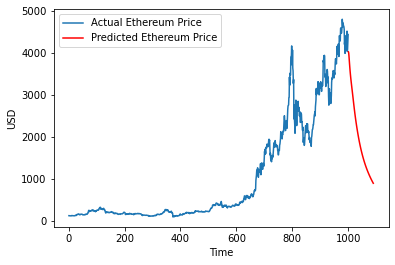

In [27]:
day_new=np.arange(1,1001)
day_pred=np.arange(1001,1091)
plt.plot(day_new,scaler.inverse_transform(eth_scaled[462:]), label = "Actual Ethereum Price")
plt.plot(day_pred,scaler.inverse_transform(output), label="Predicted Ethereum Price", color="red")
plt.xlabel("Time")
plt.ylabel("USD")
plt.legend()
plt.show()

## GRU

In [28]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 150, 50)           7950      
                                                                 
 dropout_8 (Dropout)         (None, 150, 50)           0         
                                                                 
 gru_1 (GRU)                 (None, 150, 50)           15300     
                                                                 
 dropout_9 (Dropout)         (None, 150, 50)           0         
                                                                 
 gru_2 (GRU)                 (None, 150, 50)           15300     
                                                                 
 dropout_10 (Dropout)        (None, 150, 50)           0         
                                                                 
 gru_3 (GRU)                 (None, 50)               

In [29]:
modelGRU.compile(optimizer='adam', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
55/55 [==============================] - 13s 136ms/step - loss: 3.6491e-04
Epoch 2/100
55/55 [==============================] - 7s 136ms/step - loss: 8.2102e-05
Epoch 3/100
55/55 [==============================] - 7s 135ms/step - loss: 7.8961e-05
Epoch 4/100
55/55 [==============================] - 7s 135ms/step - loss: 6.1629e-05
Epoch 5/100
55/55 [==============================] - 7s 135ms/step - loss: 7.5042e-05
Epoch 6/100
55/55 [==============================] - 7s 134ms/step - loss: 5.2665e-05
Epoch 7/100
55/55 [==============================] - 7s 134ms/step - loss: 7.7013e-05
Epoch 8/100
55/55 [==============================] - 7s 134ms/step - loss: 7.1386e-05
Epoch 9/100
55/55 [==============================] - 7s 134ms/step - loss: 7.2045e-05
Epoch 10/100
55/55 [==============================] - 7s 134ms/step - loss: 4.8797e-05
Epoch 11/100
55/55 [==============================] - 7s 134ms/step - loss: 4.6369e-05
Epoch 12/100
55/55 [==============================]

55/55 [==============================] - 7s 134ms/step - loss: 2.5311e-05
Epoch 96/100
55/55 [==============================] - 7s 133ms/step - loss: 2.5150e-05
Epoch 97/100
55/55 [==============================] - 7s 134ms/step - loss: 2.5703e-05
Epoch 98/100
55/55 [==============================] - 7s 134ms/step - loss: 2.5750e-05
Epoch 99/100
55/55 [==============================] - 7s 133ms/step - loss: 2.4733e-05
Epoch 100/100
55/55 [==============================] - 7s 134ms/step - loss: 2.8941e-05


In [30]:
#make predictions using train and test data
train_predict_gru = modelGRU.predict(X_train)
test_predict_gru = modelGRU.predict(X_test)

#tranformation to original form and making the predictions
train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)


In [31]:
print(f"Train GRU RMSE:{math.sqrt(mean_squared_error(y_train_inverse,train_predict_gru))}")
print(f"Train GRU MSE:{mean_squared_error(y_train_inverse,train_predict_gru)}")
print("-------------------------------")
print(f"Test GRU RMSE:{math.sqrt(mean_squared_error(y_test_inverse,test_predict_gru))}")
print(f"Test GRU MSE:{mean_squared_error(y_test_inverse,test_predict_gru)}")
print(f"GRU R2 score:{r2_score(y_test_inverse,test_predict_gru)}")

Train GRU RMSE:15.05262616701353
Train GRU MSE:226.58155452386043
-------------------------------
Test GRU RMSE:214.33038918427312
Test GRU MSE:45937.515727881975
GRU R2 score:0.9428733837218468
